## Machine Learning For Fuel Depletion Calculations

This jupyternotebook is to explore on a surface level a machine learning approach to predicting the fuel depletion and trasnmutation of a nuclear reactor

In [ ]:
# === Install required packages if missing === #
import sys
import subprocess
result = subprocess.run(
    [sys.executable, "-m", "pip", "install",
     "pandas", "numpy", "torch", "torch_optimizer",
     "polars", "matplotlib", "scikit-learn", "torchinfo", "torchsummary"],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL
)

# If packages are not installed this may take some time
if result.returncode != 0: print("Package installation failed.")

In [ ]:
# === System & Utility Imports === #
import math

# === Data Handling === #
import numpy as np
import pandas as pd

# === Visualization === #
import matplotlib.pyplot as plt

# === Scikit-Learn === #
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
)

# === PyTorch === #
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary


## Opening The Data and Plotting

Column keys:
 [['0' 'run_label']
 ['1' 'time_days']
 ['2' 'k_eff']
 ['3' 'k_eff_std']
 ['4' 'power_W_g']
 ['5' 'int_p_W']
 ['6' 'fuel_temp_K']
 ['7' 'mod_temp_K']
 ['8' 'clad_temp_K']
 ['9' 'mod_density_g_cm3']
 ['10' 'boron_ppm']
 ['11' 'Ag107']
 ['12' 'Ag109']
 ['13' 'Ag109_m1']
 ['14' 'Ag110']
 ['15' 'Ag110_m1']
 ['16' 'Ag111']
 ['17' 'Am241']
 ['18' 'Am242']
 ['19' 'Am242_m1']
 ['20' 'Am243']
 ['21' 'Am244']
 ['22' 'Am244_m1']
 ['23' 'B10']
 ['24' 'B11']
 ['25' 'Ba134']
 ['26' 'Ba137']
 ['27' 'Ba140']
 ['28' 'Br81']
 ['29' 'Br82']
 ['30' 'Cd110']
 ['31' 'Cd111']
 ['32' 'Cd112']
 ['33' 'Cd113']
 ['34' 'Cd114']
 ['35' 'Cd115']
 ['36' 'Ce140']
 ['37' 'Ce141']
 ['38' 'Ce142']
 ['39' 'Ce143']
 ['40' 'Ce144']
 ['41' 'Cm242']
 ['42' 'Cm243']
 ['43' 'Cm244']
 ['44' 'Cm245']
 ['45' 'Cm246']
 ['46' 'Cs133']
 ['47' 'Cs134']
 ['48' 'Cs135']
 ['49' 'Cs136']
 ['50' 'Cs137']
 ['51' 'Dy160']
 ['52' 'Dy161']
 ['53' 'Dy162']
 ['54' 'Dy163']
 ['55' 'Dy164']
 ['56' 'Dy165']
 ['57' 'Er162']
 ['58' 'Er1

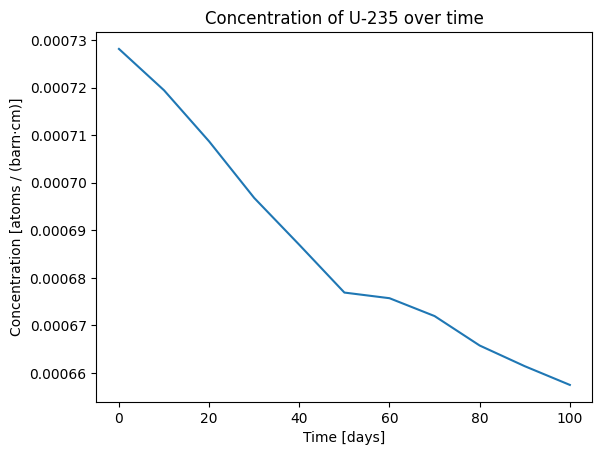

In [ ]:
data_file_path = 'data/test_small_dataset.csv'
df = pd.read_csv(data_file_path)

column_keys = np.array([(i, col) for i, col in enumerate(df.columns)])
print("Column keys:\n", column_keys)

data_array = df.to_numpy()
print("\nData array shape:", data_array.shape)

# Plotting concentration of U-235 over time
plt.plot(df['time_days'], df['U235'])
plt.title('Concentration of U-235 over time')
plt.xlabel('Time [days]')
plt.ylabel('Concentration [atoms / (barn·cm)]')
plt.show()